# 2. Monte Carlo as Probability & Integration

**Goal.** Understand Monte Carlo as an *estimator of expectations* and integrals.  
By the end of this notebook, you should be able to:
- Explain MC as a probability/integration tool.  
- Estimate π via hit–miss sampling.  
- Quantify uncertainty (standard error, confidence interval).  
- Visualize convergence with sample size.

**Roadmap.**
- 2.1 Monte Carlo as Expectation  
- 2.2 Estimating π (Hit–Miss)  
- 2.3 Convergence & Confidence Intervals  
- 2.4 Extending to General Integrals


## 2.1 Monte Carlo as Expectation

**The formula**

If $X \sim p(x)$ is a random variable, then for any function $g$:

$$
\mathbb{E}[g(X)] \;=\; \int g(x)\,p(x)\,dx.
$$

If we draw $N$ random samples $X_1, \dots, X_N$, the Monte Carlo (MC) estimator is:

$$
\hat{\mu}_N \;=\; \frac{1}{N}\sum_{i=1}^N g(X_i).
$$

**Plain explanation**

- The expectation $\mathbb{E}[g(X)]$ is the "true average" of $g(X)$ if we could observe infinitely many samples.  
- Since we can’t, we approximate it by taking a **finite average** of $N$ random draws.  
- This is exactly what Monte Carlo does: replace a hard integral with an average over random samples.  

**Error behavior**

The estimate has noise, measured by the **Standard Error (SE):**

$$
\mathrm{SE}(\hat{\mu}_N) \approx \frac{\hat{\sigma}}{\sqrt{N}},
$$

where $\hat{\sigma}^2$ is the sample variance of the $g(X_i)$.

- In words: as $N$ grows, the error shrinks like $1/\sqrt{N}$.  
- Example: if we quadruple the sample size, the error halves.


## 2.2 Estimating π via Hit–Miss

**The formula**

- Throw random points \((x,y)\) uniformly in the unit square \([0,1]^2\).  
- Define an indicator variable:
\[
I_i = \mathbf{1}\{x_i^2 + y_i^2 \le 1\}.
\]
- The average of these indicators estimates the area of the quarter circle:
\[
\mathbb{E}[I] = \pi/4.
\]
- Therefore, our estimator of π is:
\[
\widehat{\pi} = 4 \cdot \frac{1}{N}\sum_{i=1}^N I_i.
\]

**Plain explanation**

- We are throwing darts randomly into a square of size 1×1.  
- Some darts land inside the quarter circle (radius 1 in the corner).  
- The fraction of darts inside the circle ≈ area of circle / area of square = π/4.  
- Multiply this fraction by 4, and we get an estimate of π.  

**Uncertainty**

The standard error comes from the variability of the hits/misses:
\[
\mathrm{SE} = 4 \sqrt{\frac{\hat{p}(1-\hat{p})}{N}}, \quad 
\hat{p} = \frac{1}{N}\sum I_i.
\]

In words:  
- \(\hat{p}\) is just the proportion of points inside the circle.  
- The SE shrinks as we add more samples.  
- A 95% confidence interval is the estimate ± 2·SE.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
DEFAULT_SEED = 42
rng = np.random.default_rng(DEFAULT_SEED)

def f4(x: float) -> str:
    """Pretty formatting for floats"""
    return f"{x:.4f}"


In [2]:
from typing import Tuple, Optional

def estimate_pi_hitmiss(
    n_samples: int,
    rng: np.random.Generator,
    return_points: bool = False
) -> Tuple[float, float, Tuple[float, float], Optional[tuple]]:
    """
    Estimate π using hit–miss Monte Carlo in the unit square.

    Method
    ------
    - Draw (x_i, y_i) ~ Uniform([0,1]^2), i=1..N.
    - Indicator I_i = 1 if x_i^2 + y_i^2 <= 1, else 0.
    - p_hat = (1/N) * sum I_i  ≈  area of quarter circle = π/4.
    - pi_hat = 4 * p_hat.

    Uncertainty (approx. 95% CI using normal approximation):
    - SE = 4 * sqrt(p_hat*(1-p_hat)/N)
    - CI = [pi_hat - 1.96*SE, pi_hat + 1.96*SE]

    Parameters
    ----------
    n_samples : int
        Number of random points to draw.
    rng : np.random.Generator
        Numpy random generator (for reproducibility).
    return_points : bool
        If True, also return (x, y, inside_mask) for visualization.

    Returns
    -------
    pi_hat : float
        Monte Carlo estimate of π.
    se : float
        Standard error of the estimate.
    ci : (float, float)
        95% confidence interval (lower, upper).
    pts : tuple or None
        If return_points=True, returns (x, y, inside_mask), else None.
    """
    # Draw points in [0,1]^2
    x = rng.random(n_samples)
    y = rng.random(n_samples)

    # Inside quarter circle?
    inside = (x*x + y*y) <= 1.0

    # Proportion inside (area ≈ π/4)
    p_hat = inside.mean()
    pi_hat = 4.0 * p_hat

    # Binomial-based SE for p_hat, propagated to π
    se = 4.0 * math.sqrt(max(p_hat * (1.0 - p_hat), 0.0) / n_samples)

    # 95% normal CI
    ci_low = pi_hat - 1.96 * se
    ci_high = pi_hat + 1.96 * se

    pts = (x, y, inside) if return_points else None
    return pi_hat, se, (ci_low, ci_high), pts


In [3]:
N = 20_000  # try 2_000, 20_000, 200_000 to feel the √N effect
pi_hat, se, (ci_low, ci_high), _ = estimate_pi_hitmiss(N, rng, return_points=False)

print(f"N = {N}")
print(f"π estimate     : {f4(pi_hat)}")
print(f"Std. error     : {f4(se)}")
print(f"95% CI         : [{f4(ci_low)}, {f4(ci_high)}]")
print(f"True π         : {f4(math.pi)}  (inside CI? {'yes' if (ci_low<=math.pi<=ci_high) else 'no'})")


N = 20000
π estimate     : 3.1430
Std. error     : 0.0116
95% CI         : [3.1203, 3.1657]
True π         : 3.1416  (inside CI? yes)


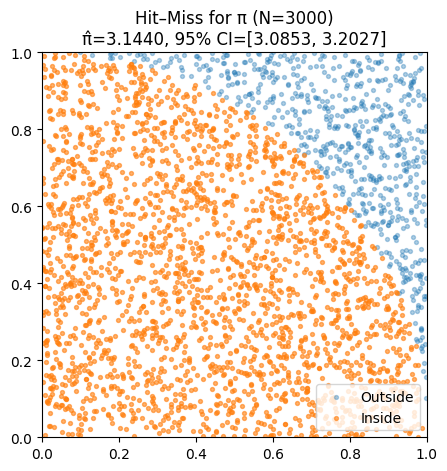

In [4]:
# Smaller N for a readable scatter
N_scatter = 3_000
pi_hat_s, se_s, (ci_l_s, ci_h_s), pts = estimate_pi_hitmiss(N_scatter, rng, return_points=True)
x, y, inside = pts

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x[~inside], y[~inside], s=8, alpha=0.35, label="Outside")
ax.scatter(x[inside], y[inside], s=8, alpha=0.6, label="Inside")
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_title(f"Hit–Miss for π (N={N_scatter})\nπ̂={f4(pi_hat_s)}, 95% CI=[{f4(ci_l_s)}, {f4(ci_h_s)}]")
ax.legend(loc="lower right")
plt.show()


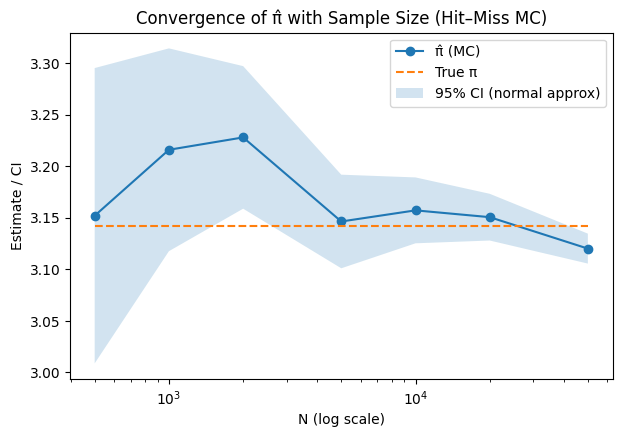

In [5]:
Ns = [500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000]
estimates, ses, ci_lows, ci_highs = [], [], [], []

# Fresh RNG for a clean sweep (optional)
rng_conv = np.random.default_rng(123)

for n in Ns:
    pi_hat_i, se_i, (ci_l_i, ci_h_i), _ = estimate_pi_hitmiss(n, rng_conv, return_points=False)
    estimates.append(pi_hat_i); ses.append(se_i)
    ci_lows.append(ci_l_i); ci_highs.append(ci_h_i)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(Ns, estimates, marker='o', label="π̂ (MC)")
ax.plot(Ns, [math.pi]*len(Ns), linestyle='--', label="True π")
ax.fill_between(Ns, ci_lows, ci_highs, alpha=0.2, label="95% CI (normal approx)")
ax.set_xscale('log')
ax.set_xlabel("N (log scale)")
ax.set_ylabel("Estimate / CI")
ax.set_title("Convergence of π̂ with Sample Size (Hit–Miss MC)")
ax.legend()
plt.show()


## 2.3 Convergence & Confidence Intervals

In the scatter plot and the convergence plot, we can see several key points:

1. **Convergence rate (√N law).**  
   The Monte Carlo estimate of π improves as we add more samples.  
   - The error (measured by the standard error, SE) decreases roughly like $1/\sqrt{N}$.  
   - Example: going from 5,000 to 20,000 samples multiplies $N$ by 4, which should cut the error by about half.

2. **Confidence intervals.**  
   Each estimate comes with a 95% confidence interval (CI):  

   $$
   \widehat{\pi} \pm 1.96 \cdot \mathrm{SE}.
   $$

   - The CI is wider for small $N$ and gets narrower as $N$ increases.  
   - By construction, about 95% of such intervals should contain the true π.  

3. **Random variation.**  
   Even with large $N$, there is still randomness:  
   - The estimate bounces around the true value.  
   - Sometimes, by chance, the CI may *not* contain π. This is expected and normal.

**Takeaway:**  
Monte Carlo is guaranteed to converge in the long run, but the convergence is slow ($O(1/\sqrt{N})$). This is why variance reduction techniques (later) are so valuable in practice.


## 2.4 General Integrals

Monte Carlo is not limited to geometry — it can approximate **any integral**.

**The formula**

Suppose we want to compute:

$$
I = \int_0^1 f(x)\,dx.
$$

If we draw $x_1, x_2, \dots, x_N \sim U[0,1]$ (uniform samples in [0,1]), then:

$$
\hat{I}_N = \frac{1}{N} \sum_{i=1}^N f(x_i).
$$

- This works because under the uniform distribution on [0,1], the expectation of $f(x)$ equals the integral:

$$
\mathbb{E}[f(X)] = \int_0^1 f(x)\,dx.
$$

**Plain explanation**

- Think of it as picking random points on the x-axis between 0 and 1.  
- Evaluate the function at those points, then take the average.  
- That average is an estimate of the integral (the "area under the curve").  

Monte Carlo integration is like asking:  
*"If I randomly pick lots of points between 0 and 1, what is the average height of the function at those points?"*

- Each sample \(x_i\) is a random location in [0,1].  
- We compute \(f(x_i)\), the function’s value there.  
- By averaging all these values, we approximate the overall “average height” of the curve.  
- Since the width of the interval is 1, this average is the same as the integral (the area under the curve).  

**In our example:**  
For \(f(x) = e^{-x^2}\), the curve starts at \(f(0)=1\) and smoothly decreases to about \(f(1)=0.367\).  
The Monte Carlo method estimates the area under this curve between 0 and 1.  
Even though there’s no neat closed form, Monte Carlo gives a quick and accurate estimate — with uncertainty shrinking as we add more points.


**Example**

We’ll try:

$$
f(x) = e^{-x^2}, \quad I = \int_0^1 e^{-x^2}\,dx.
$$

This integral does not have a simple closed form, but we can compare our Monte Carlo estimate to a high-precision numerical integration (from SciPy).


Monte Carlo integration is essentially **approximating the area under a curve by throwing random points**:

* Imagine the curve $f(x)$ between 0 and 1.
* Each time you pick a random $x$ in \[0,1], you’re “sampling” the height of the curve at that point.
* If you average many such sampled heights, you get the *average height of the function*.
* Since the base length is 1, the area under the curve ≈ average height × base length = just that average.

In the π example, the function is just the indicator of whether a dart falls inside the quarter circle or not. In the integral example with $f(x) = e^{-x^2}$, the “darts” are the random $x$-values, and we average the function values to approximate the shaded area under the curve.

It’s the same principle: **random sampling to replace a hard integral with a simple average**.



In [6]:
import scipy.integrate as integrate

def mc_integral(f, n_samples: int, rng: np.random.Generator):
    """
    Monte Carlo estimate of ∫_0^1 f(x) dx using uniform sampling.
    """
    x = rng.random(n_samples)  # uniform samples in [0,1]
    fx = f(x)
    estimate = fx.mean()
    se = fx.std(ddof=1) / np.sqrt(n_samples)
    ci_low = estimate - 1.96 * se
    ci_high = estimate + 1.96 * se
    return estimate, se, (ci_low, ci_high)

# Target function
f = lambda x: np.exp(-x**2)

# Monte Carlo estimate
N = 50_000
estimate, se, (ci_low, ci_high) = mc_integral(f, N, rng)

# Reference value (numerical integration)
true_val, _ = integrate.quad(lambda t: math.exp(-t**2), 0, 1)

print(f"N = {N}")
print(f"MC estimate   : {f4(estimate)}")
print(f"Std. error    : {f4(se)}")
print(f"95% CI        : [{f4(ci_low)}, {f4(ci_high)}]")
print(f"True value    : {f4(true_val)}")


N = 50000
MC estimate   : 0.7467
Std. error    : 0.0009
95% CI        : [0.7450, 0.7485]
True value    : 0.7468


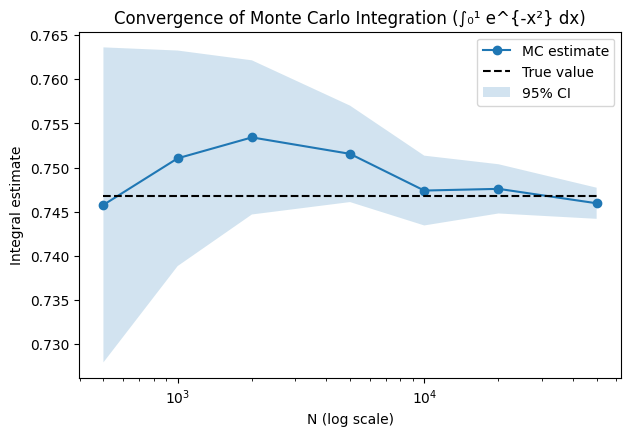

In [7]:
Ns = [500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000]
estimates, ci_lows, ci_highs = [], [], []

rng_conv = np.random.default_rng(123)

for n in Ns:
    est, se, (ci_low, ci_high) = mc_integral(f, n, rng_conv)
    estimates.append(est)
    ci_lows.append(ci_low)
    ci_highs.append(ci_high)

# True reference value
true_val, _ = integrate.quad(lambda t: math.exp(-t**2), 0, 1)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(Ns, estimates, marker='o', label="MC estimate")
ax.plot(Ns, [true_val]*len(Ns), linestyle='--', color="black", label="True value")
ax.fill_between(Ns, ci_lows, ci_highs, alpha=0.2, label="95% CI")
ax.set_xscale("log")
ax.set_xlabel("N (log scale)")
ax.set_ylabel("Integral estimate")
ax.set_title("Convergence of Monte Carlo Integration (∫₀¹ e^{-x²} dx)")
ax.legend()
plt.show()


## Monte Carlo in Higher Dimensions

**The problem:**

* In 1D, integrals are usually manageable with classical numerical methods (like Simpson’s rule, trapezoids, etc.).
* But in higher dimensions (say, a 10-dimensional integral), classical methods become impossible because the number of grid points explodes exponentially — this is called the **curse of dimensionality**.

**Monte Carlo’s advantage:**

* Monte Carlo doesn’t care about the number of dimensions.
* The error still decreases at the same rate, $O(1/\sqrt{N})$, regardless of whether you’re in 1D, 10D, or 1000D.
* This makes MC the go-to method in physics, finance, and statistics for problems where integrals live in huge spaces.

---

### Simple example: 2D area under a surface

Say we want:

$$
I = \int_0^1 \int_0^1 f(x,y)\,dx\,dy.
$$

* We draw random points $(x_i,y_i)$ uniformly in the unit square.
* We average $f(x_i,y_i)$.
* That average approximates the integral — the “volume under the surface” of $f(x,y)$.

For instance, with $f(x,y) = e^{-(x^2+y^2)}$, you’re estimating the volume under a smooth “bump” shape.

---

### Why this matters

* In **finance**, pricing exotic options often requires expectations in very high dimensions (multiple time steps, correlated assets).
* In **physics/engineering**, particle transport or statistical mechanics involve integrals over huge state spaces.
* In **machine learning**, Bayesian inference often requires expectations over high-dimensional probability distributions.

All of these rely heavily on Monte Carlo methods, because they don’t suffer (as badly) from the curse of dimensionality.

---

👉 So the intuition scales up:
It’s still just “throwing random darts” — but now in higher-dimensional boxes, and averaging function values at those dart points.

---


## 2.5 High-Dimensional Monte Carlo (2D demo)

**Goal.** Estimate a **2D integral** (volume under a surface) by random sampling in a square.

**Problem**

$$
I \;=\; \int_0^1\int_0^1 e^{-(x^2 + y^2)} \, dx\,dy.
$$

**MC idea (formula)**
- Draw i.i.d. points $(x_i, y_i) \sim \mathrm{Uniform}([0,1]^2)$.
- Average the function values:

$$
\hat I_N \;=\; \frac{1}{N}\sum_{i=1}^N f(x_i,y_i).
$$

- The **standard error** (SE) is the sample std of $f(x_i,y_i)$ divided by $\sqrt{N}$; a 95% CI is $\hat I_N \pm 1.96\,\mathrm{SE}$.

**Plain-language**
- Think “throw darts” in a unit square on the $xy$-plane.  
- Look at the surface height $f(x,y)$ at each dart.  
- The **average height** across many random darts ≈ the **volume** under the surface over the square.


In [8]:
import scipy.integrate as integrate

def mc_integral_2d(f, n_samples: int, rng: np.random.Generator):
    """
    Monte Carlo estimate of ∬_{[0,1]^2} f(x,y) dx dy using uniform sampling.
    Returns (estimate, se, (ci_low, ci_high)).
    """
    x = rng.random(n_samples)
    y = rng.random(n_samples)
    vals = f(x, y)
    est = vals.mean()
    se = vals.std(ddof=1) / np.sqrt(n_samples)
    ci_low = est - 1.96 * se
    ci_high = est + 1.96 * se
    return est, se, (ci_low, ci_high)

# Target function and true value (via numerical integration)
f2d = lambda x, y: np.exp(-(x**2 + y**2))

# Note: dblquad integrates in order: y (inner), then x (outer)
true_val_2d, _ = integrate.dblquad(
    lambda yy, xx: math.exp(-(xx**2 + yy**2)),
    0.0, 1.0,  # xx bounds
    lambda xx: 0.0, lambda xx: 1.0  # yy bounds as functions of xx
)

N2 = 50_000
est2, se2, (ci2_l, ci2_h) = mc_integral_2d(f2d, N2, rng)

print(f"N = {N2}")
print(f"MC estimate   : {f4(est2)}")
print(f"Std. error    : {f4(se2)}")
print(f"95% CI        : [{f4(ci2_l)}, {f4(ci2_h)}]")
print(f"True value    : {f4(true_val_2d)}  (inside CI? {'yes' if (ci2_l <= true_val_2d <= ci2_h) else 'no'})")


N = 50000
MC estimate   : 0.5587
Std. error    : 0.0010
95% CI        : [0.5568, 0.5606]
True value    : 0.5577  (inside CI? yes)


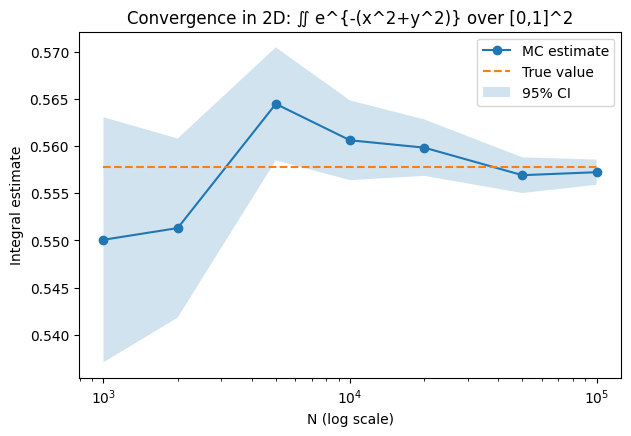

In [9]:
Ns = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
estimates, ci_lows, ci_highs = [], [], []

rng2 = np.random.default_rng(2025)

for n in Ns:
    est, se, (ci_l, ci_h) = mc_integral_2d(f2d, n, rng2)
    estimates.append(est)
    ci_lows.append(ci_l)
    ci_highs.append(ci_h)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(Ns, estimates, marker='o', label="MC estimate")
ax.plot(Ns, [true_val_2d]*len(Ns), linestyle='--', label="True value")
ax.fill_between(Ns, ci_lows, ci_highs, alpha=0.2, label="95% CI")
ax.set_xscale("log")
ax.set_xlabel("N (log scale)")
ax.set_ylabel("Integral estimate")
ax.set_title("Convergence in 2D: ∬ e^{-(x^2+y^2)} over [0,1]^2")
ax.legend()
plt.show()
